# Analysis of Sentinel Data
authors: Tuguldur Sukhbold

### Basic handling

Here we will explore the temporal aspect of Sentinel data, and try to evaluate whether we can use them to locate the maize fields in Planet images.

Let's take a Sentinel image of a sample field with ID = ff4174be. Here note that all Sentinel images are in TIFF format (vs PNG in Planet set), and they are *not* standard TIFF files with full headers. So we actually cannot open them with the usual python packages like PIL or Tiffile, and instead we'll be using the approach suggested by the organizers through skimage: 

In [1]:
datapath = '../../d/sentinel/'

from skimage.io import imread as rdtif

fieldID = 'ff4174be'
fname = f'{fieldID}.tif'
img = rdtif(f'{datapath}{fname}')

img.shape

(41, 41, 192)

the img object above is 3D numpy array. The first two numbers (41,41) are number of pixels in each direction, and the last number 192 denotes the number of channels in each image. Here comes the unique feature of Sentinel images that every single one of them is composed of not only frames in different bands, but also frames captured at different times. In contrast, Planet images have only 3 channels (the usual Red Green Blue) and all 3 represent frames captured at a single point in time.

There was some confusion early on as to where this 192 comes from but now we fully understand it. As listed in *ImageBands.docx* file, each Sentinel image has data from 16 filters. Furthermore, each image TIFF file contains 12 images taken with each of these 16 filters throughout the year, i.e. 12 x 16 = 192:

img[:, :, 0] = filter#1 month#1\
img[:, :, 1] = filter#2 month#1\
...\
img[:, :, 15]= filter#16 month#1\
img[:, :, 16]= filter#1 month#2\
...\
img[:, :, 191]= filter#16 month#12

Let's visualize a set of 16 frames taken with each filter for this image during the first month, so it would be the first 16 slices of img:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.cm.gray

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,16), sharex=True, sharey=True)

band = 0
for i,j in np.ndindex(ax.shape):
    ax[i, j].imshow(img[:, :, band], cmap=cmap)
    ax[i, j].set_title(f'Filter = {band+1}')
    band += 1

plt.show()

<Figure size 1600x1600 with 16 Axes>

Note that all images are (41,41) in size and they vary in apparent resolution across different filters. Frames look better in filters 3 and 4, really poor in filters 1, 10, and 11, and the last 3 don't show any meaningful image data. Now let's look at the same from the next month (img slices from 16 to 28):

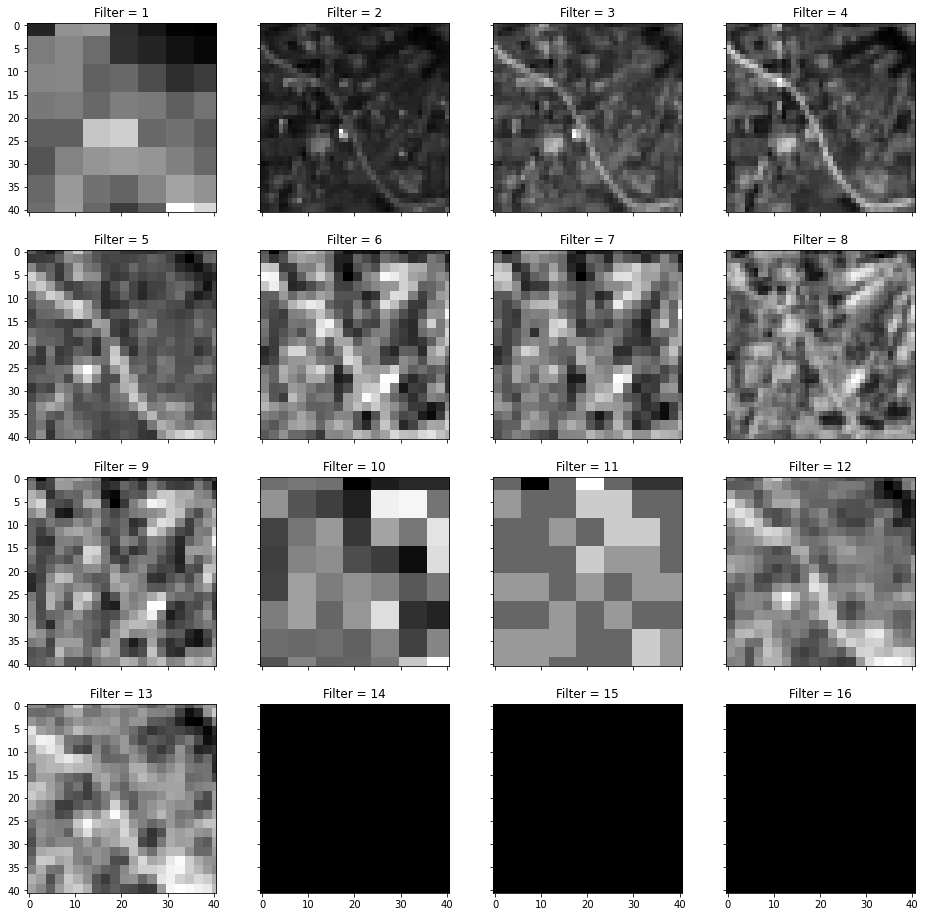

In [3]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,16), sharex=True, sharey=True)

band = 16
for i,j in np.ndindex(ax.shape):
    ax[i, j].imshow(img[:, :, band], cmap=cmap)
    ax[i, j].set_title(f'Filter = {band-15}')
    band += 1

plt.show()

Here we can actually see some land structures clearly in filters 3 and 4. This means that the data from the prior month were taken when it was cloudy, and things are much clearer in the 2nd month.

Now would be a good time to look at ImageBands.docx more carefully. There notice the last 3 entries are special - they are not image frames. QA10 and QA20 are always empty as you can see Filters 14 and 15 are both completely dark in both months. The last one which we label as Filter 16 is actually a cloud mask - tells us approximately what part of the image in real filters (1 through 13) were covered by cloud. In the 1st month data you can see that Filter 16 is mostly white, meaning almost entire image is blocked, and that is why all images look same gray in real filters. Obviously cloud covered images are useless to us, but its nice to have these cloud masks which we can use to infer the usability of any given set of frames taken in one month.

Let's move on to the actual time-series analysis. Here the idea is that eventhough Sentinel images have much poorer resolution than Planet, because it has much more denser time coverage it actually might be useful for us to locate the maize fields. Obviously plants grow and die throughout the year, and accordingly the profile of their reflections (of sun light) change dramatically. The hope is that if we can identify these changes, they might help us to know where in Planet images things are growing and dying.

We don't want to mixup different filters for time-series analysis, so let's write a function that sorts all the frames in a given field image file through their filters:

In [4]:
from itertools import product as iterp

# filter IDs ranging from 1 to 16
filters = np.arange(16, dtype=int) + 1
# months 1 to 12
months = np.arange(12) + 1

def getSentinelTimeData(path2tif):
    """
    process input Sentinel TIFF file to map its contents into a filter dictionary
    """
    
    # read TIFF file into 3D array
    img = rdtif(path2tif)
    
    # initialize the dict with empty list for each filter
    d = {}
    for filter in filters: d[filter] = []
    
    # populate with 2D images
    for i, j in iterp(months, filters):
        channel = (i - 1) * len(filters) + j - 1
        d[j].append(img[:, :, channel])
        
        
    return d



d = getSentinelTimeData(f'{datapath}{fname}')

# all 12 images of filter#1
len(d[1])

12

To make sure its correct let's try plotting all 12 month images for a sample filter#4 and their corresponding cloud masks (filter#16): 

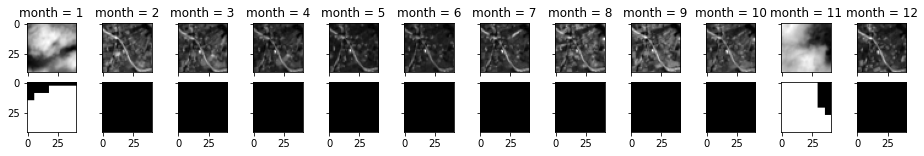

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=len(months), figsize=(len(filters),2), sharex=True, sharey=True)

for i,j in np.ndindex(ax.shape):
    ax[0,j].imshow(d[4][j], cmap=cmap)
    ax[0,j].set_title(f'month = {j+1}')
    ax[1,j].imshow(d[16][j], cmap=cmap)

plt.show()

We can see that images from months #1 and #11 were covered in clouds, and there is a clear variation in intensity across months. Its dimmest around months#4-6 and possibly it becomes dim again around month#12.

Below we update our function with several features: (1) a small fraction of Sentinel images are known to have much fewer channels than 192; the organizers of the competition provide no information whatsoever on how to handle those, and so our function won't process them; (2) through a flag that is set True by default it now automatically filters cloudy images based on the mask, and returns only real filter data; (3) returns normalized images with intensities ranging between 0 and 1.

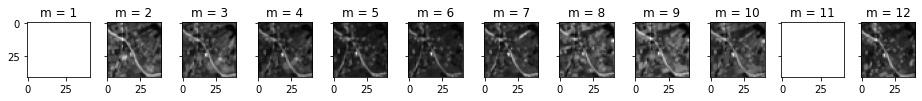

In [6]:
from sys import exit

def getSentinelTimeData(path2tif, filterCloudy=True):
    """
    process input Sentinel TIFF file to map its contents into a dictionary
    with filter keys and monthly images as values
    
    note: it won't process images with number of channels other than 192
    
    when filterCloudy flag is True:
    - excludes cloudy images based on cloud-mask (filter#16)
    - final dictionary contains 13 real filter data
    """
    
    # filter and month IDs
    filters = np.arange(16, dtype=int) + 1
    months  = np.arange(12) + 1

    # read TIFF file into 3D array
    img = rdtif(path2tif)
    
    # stop if its a funky image, proceed only if there are usual 192 channels:
    if img.shape[-1] != 192: exit(f' cannot process this funky image with {img.shape[-1]} channels')
    
    # initialize the dict with empty list for each filter
    d = {}
    for f in filters: d[f] = []
    
    # populate with 2D images
    for i, j in iterp(months, filters):

        channel = (i - 1) * len(filters) + j - 1
        
        # append normalized image
        maxFrame = np.amax(img[:, :, channel])
        if maxFrame == 0.:
            d[j].append(img[:, :, channel])
        else:
            d[j].append(img[:, :, channel] / maxFrame)
    
    # exclude cloudy images
    if filterCloudy:
        
        for f in filters:
            for month in months:
                
                # max value of cloud mask image
                maxCloudMask = np.amax(d[16][month-1])
                
                # its cloudy if max is not 0
                if maxCloudMask != 0: d[f][month-1] = None
        
        # we don't need the last 3 elements
        del d[16] # cloudmask itself
        del d[15] # QA20
        del d[14] # QA10

    return d


d = getSentinelTimeData(f'{datapath}{fname}')

# now the filter#4 images for months 1 and 11 will be None type
fig, ax = plt.subplots(nrows=1, ncols=len(months), figsize=(len(filters),1), sharex=True, sharey=True)

for i in range(len(ax)):
    if d[4][i] is not None: ax[i].imshow(d[4][i], cmap=cmap)
    ax[i].set_title(f'm = {i+1}')

plt.show()

If we now visualize the entire set of 13 filters and 12 months, we get:

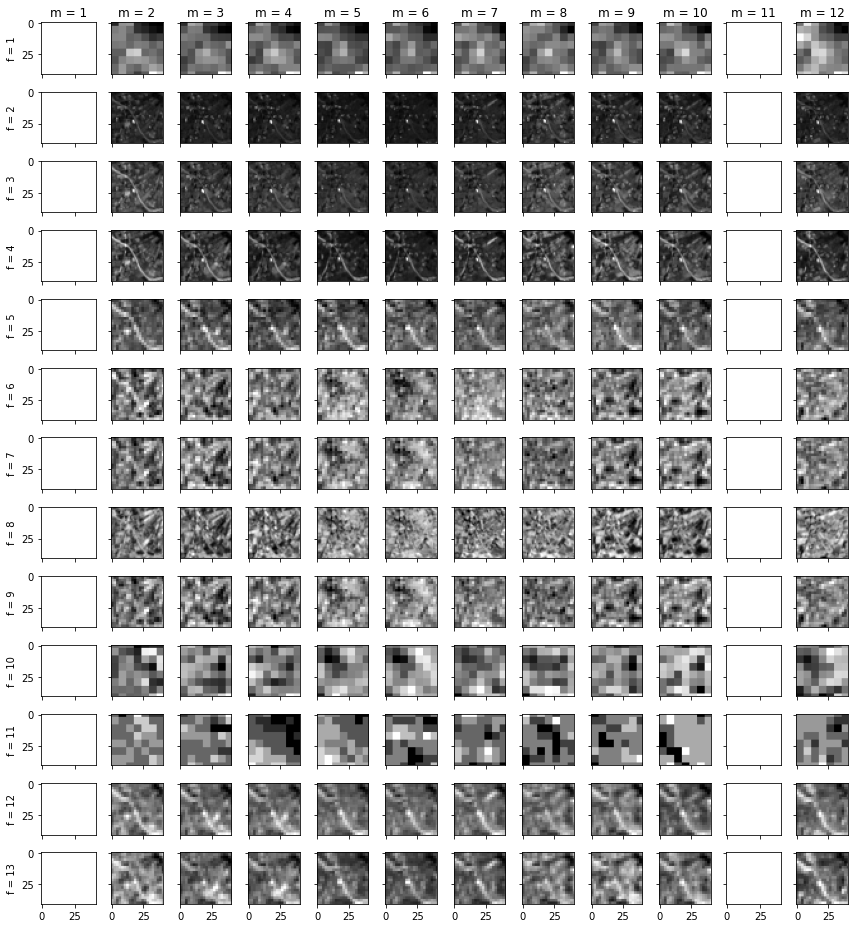

In [7]:
# update filters (13 instead of 16)
filters = np.arange(13, dtype=int) + 1
nr, nc = len(filters), len(months)

fig, ax = plt.subplots(nrows=nr, ncols=nc, figsize=(nc, nr), sharex=True, sharey=True)

for i,j in np.ndindex(ax.shape):
    if d[i+1][j] is not None: ax[i,j].imshow(d[i+1][j], cmap=cmap)
    if i == 0: ax[i,j].set_title(f'm = {j+1}')
    if j == 0: ax[i,j].set_ylabel(f'f = {i+1}')

plt.tight_layout()
plt.show()

With all the basic stuff sorted we can now move on to the mapping section. There are essentially two directions that can be pursued separately or in conjunction: (1) evaluate time variation per pixel in a given filter, and (2) explore difference imaging; both will be elaborated below.


### Maps based on pixel temporal variation

The core idea is that we can now evaluate intensity variation in each pixel for 12 months, and if we can evaluate relative variations of all pixels in a given filter, we might be able to identify the regions coinciding with maize fields. Structures like buildings and roads should have little or no variation, while growing and dying plants would exhibit large variations due to its changing reflectivity.

Let's start simple - how the intensity of just one pixel located at the top-middle change in filter#4? let's check just month#5 image for the pixel at x=20 and y=3 (note that y-axis is inverted in all plots!):

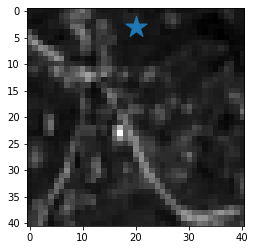

0.36577992744860943

In [8]:
# location of a sample pixel somewhere near top-middle
i, j = 20, 3
# filter#4 image of month#5
f, m = 4, 5

fig = plt.subplots()
plt.imshow(d[f][m-1], cmap=cmap)
plt.scatter(i, j, marker='*', s=500)
plt.show()

# intensity of the pixel
d[f][m-1][i,j]

this is the value just for month#5, if we put together all months:

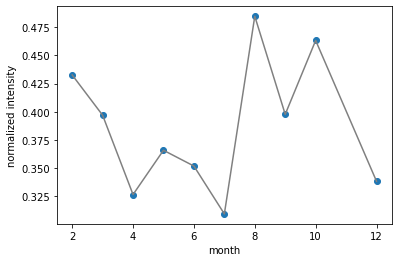

 range = 0.17555382485289028


In [9]:
x = [m for m in months if d[f][m-1] is not None]
y = [d[f][m-1][i,j] for m in months if d[f][m-1] is not None]

fig = plt.subplots()
plt.scatter(x, y)
plt.plot(x, y, c='gray')
plt.xlabel('month'), plt.ylabel('normalized intensity')
plt.show()

print(f' range = {max(y) - min(y)}')

Obviously we are missing data for month#1 and #11 (due to clouds, see above), but we can clearly see that there is a significant variation likely associated with changes due to seasons. One useful measure here is the absolute range of the variation, for this specific pixel is around 0.25.

If we go a step further and do the same measurement across all 41 pixels on the same column (x=20), and look at their variations:

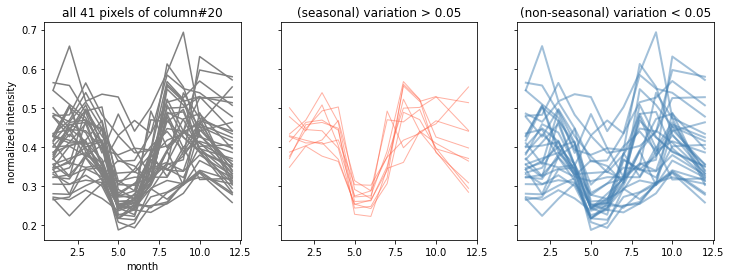

In [10]:
def getPixelIntensity(x, y, img, cyclic=True):
    """
    returns intensity as a function of time
    for a given pixel (x,y) in given list of 
    2D image arrays of 12 months
    
    when cyclic flag is True:
    - periodic linear interpolation to fill missing data
    """
    
    months = np.arange(len(img)) + 1
    
    t = [m             for m in months if img[m-1] is not None]
    i = [img[m-1][x,y] for m in months if img[m-1] is not None]
    
    # interpolate to fill cloudy data
    if cyclic:
        months = np.arange(12) + 1
        i = np.interp(months, t, i, period=len(months))
        t = months
    
    return np.array(t), np.array(i)


# separation intensity
sepInt = 0.1

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey=True)
for i in range(d[f][4].shape[0]):
    
    x,y = getPixelIntensity(20, i, d[f])
    ax[0].plot(x, y, color='gray')
    ax[0].set(xlabel='month', ylabel='normalized intensity', title='all 41 pixels of column#20')
    
    rng2 = y[7] - y[4]
    rng1 = y[3] - y[5]
    if rng1 > sepInt and rng2 > sepInt:
        c, lw = 'tomato', 1
        ax[1].plot(x, y, color=c, lw=lw, alpha=0.5)
        ax[1].set_title('(seasonal) variation > 0.05')
    else:
        c, lw = 'steelblue', 2
        ax[2].plot(x, y, color=c, lw=lw, alpha=0.5)
        ax[2].set_title('(non-seasonal) variation < 0.05')

        
plt.show()

Here the left most panel shows variations in all 41 pixels, and we immediately notice that there is a class of pixels that tend vary seasonally, and there is another class(es) of pixels where the variation is pretty minimal or more chaotic. The middle and right panels illustrate a simple attempt to separate the two. Since there is a strong change in seasonal pixels between months 5--8, and 4--5, by measuring the changes in these time ranges (see variables *rng1*, *rng2*, and *sepInt*) we can do an approximate job of classifying them. Most of the seasonal pixels (red) in the middle panel, and the rest (blue) in the right panel.

Remember that all this is just a single column in the image of filter#4. Would we see similar patterns in the other filters? let's check:

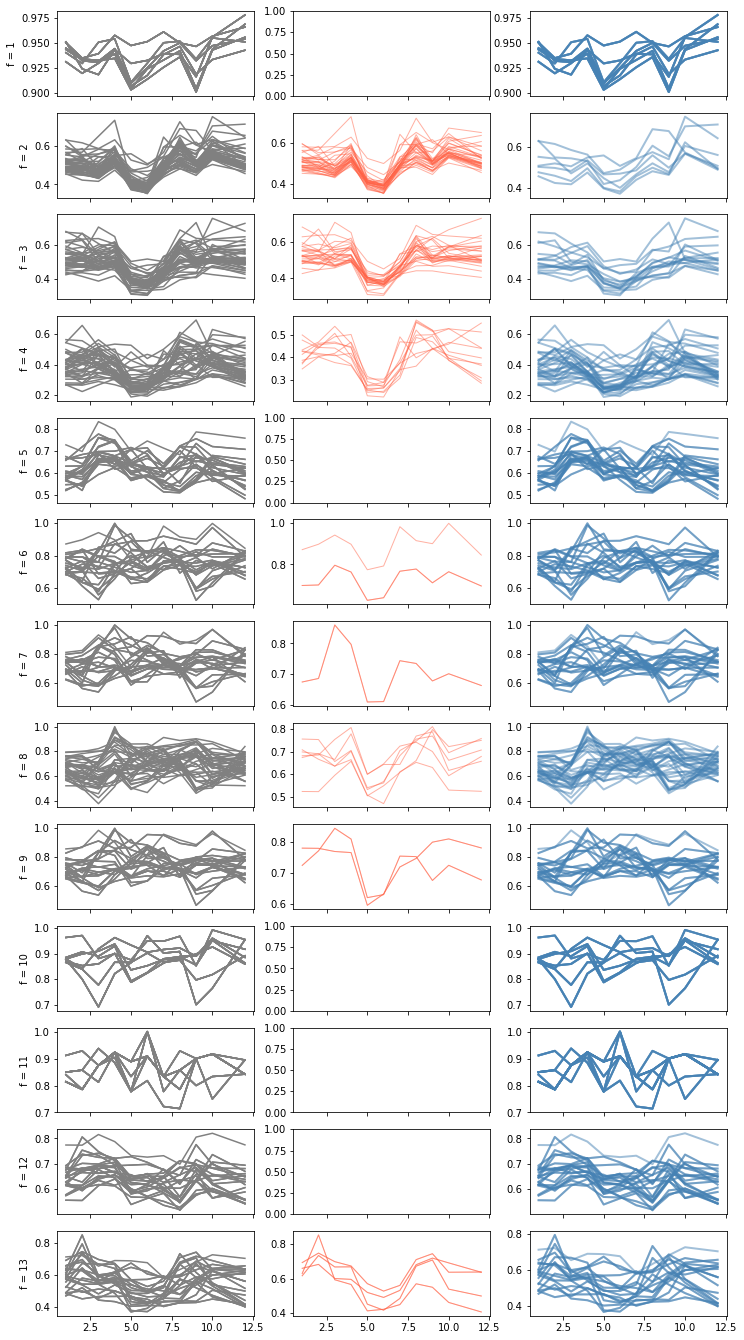

In [11]:
fig, ax = plt.subplots(nrows=len(filters), ncols=3, figsize=(12,24), sharex=True)

for f in filters:
    for i in range(d[f][4].shape[0]):
        
        x,y = getPixelIntensity(20, i, d[f])
        ax[f-1, 0].plot(x, y, color='gray')
        ax[f-1, 0].set_ylabel(f'f = {f}')

        rng2 = y[7] - y[4]
        rng1 = y[3] - y[5]
        if rng1 > sepInt and rng2 > sepInt:
            c, lw = 'tomato', 1
            ax[f-1, 1].plot(x, y, color=c, lw=lw, alpha=0.5)
        else:
            c, lw = 'steelblue', 2
            ax[f-1, 2].plot(x, y, color=c, lw=lw, alpha=0.5)

        
plt.show()

this is quite something! we see that filters 2,3, and 4 are generally similar, but because the resolution in 2 and 3 are much lower than 4, the curves are less diverse and according to our criterion most or all pixels become seasonal. Filter 13 is interesting, that even though it is quite far in IR, shows similar delienation as in filter#4. For filters 5 through 8 I can't seem to notice any clear clustering, and filters 1, 11, 10 are just low resolution garbage.

Here is a sample result analyzing all pixels of filter#13 in time to create a mask, and comparing to filter#4 image at 9 months:

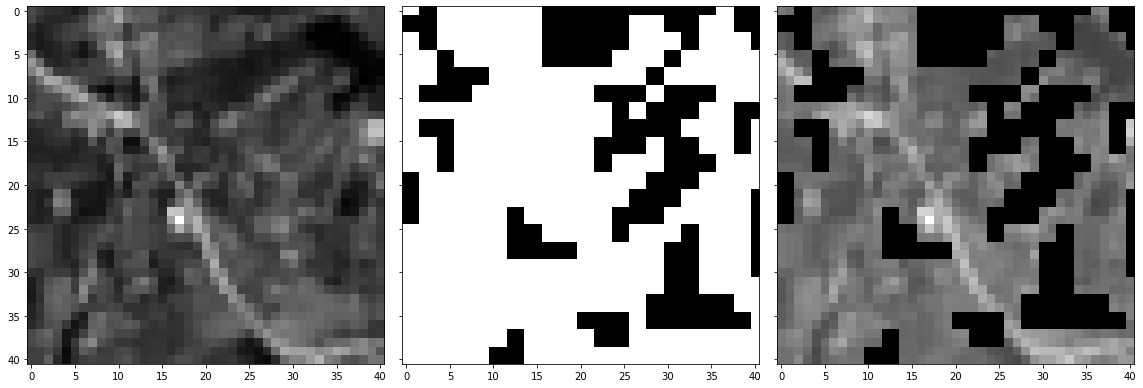

In [12]:
sampleChannel = d[4][1].copy()
sepInt = 0.1

for i,j in np.ndindex(sampleChannel.shape):
        
        x,y = getPixelIntensity(i, j, d[13])

        rng2 = y[7] - y[4]
        rng1 = y[3] - y[5]
        if rng1 > sepInt and rng2 > sepInt:
            sampleChannel[i, j] = 0
        else:
            sampleChannel[i, j] = 1

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6), sharex=True, sharey=True)
ax[0].imshow(d[4][9], cmap=cmap)
ax[1].imshow(sampleChannel, cmap=cmap)
ax[2].imshow(d[4][9]*sampleChannel, cmap=cmap)
plt.tight_layout()
plt.show()

### Maps based on difference imaging

The idea here is to explore whether we can map out maize fields by computing various color indices. There is extensive literature on remote sensing (just google "sentinel maize field"), many of them utilizing the same Sentinel-2 data. Here we check 2 specific indices that were noted to highly correlate with vegetation - Normalized Difference Vegetation Index (NDVI), which is employed virtually by all recent remote sensing studies, and Three-Band Water Index (TBWI) that was highlighted in <a href='https://www.sciencedirect.com/science/article/pii/S2214514119300881'>this</a> study. Their computations are straightforward: 

$NDVI = \frac{B7 − B4}{B7 + B4}$

$TBWI = \frac{B9 − B11}{B10}$

let's compute them for our sample image and see whats up:

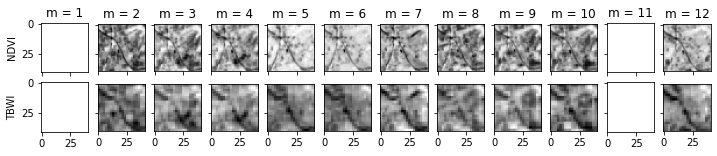

In [13]:
def getIndex(d, ID):
    l = []
    for m in range(len(d[1])):
        if d[f][m] is None:
            indx = None
        else:
            if ID == 'NDVI': indx = (d[7][m] - d[4][m]) / (d[7][m] + d[4][m])
            if ID == 'TBWI': indx = (d[10][m] - d[12][m]) / d[11][m]
        
        l.append(indx)                

    return l

NDVI = getIndex(d, ID = 'NDVI')
TBWI = getIndex(d, ID = 'TBWI')

nr, nc = 2, len(months)
fig, ax = plt.subplots(nrows=nr, ncols=nc, figsize=(nc, nr), sharex=True, sharey=True)

i=0
for j in range(nc):
    if d[i+1][j] is not None:
        ax[i,j].imshow(NDVI[j], cmap=cmap)
    ax[i,j].set_title(f'm = {j+1}')
    if j == 0: ax[i,j].set_ylabel(f'NDVI')

i=1
for j in range(nc):
    if d[i+1][j] is not None:
        ax[i,j].imshow(TBWI[j], cmap=cmap)
    if j == 0: ax[i,j].set_ylabel(f'TBWI')


looks very interesting! let's now create pixel variation maps for each:

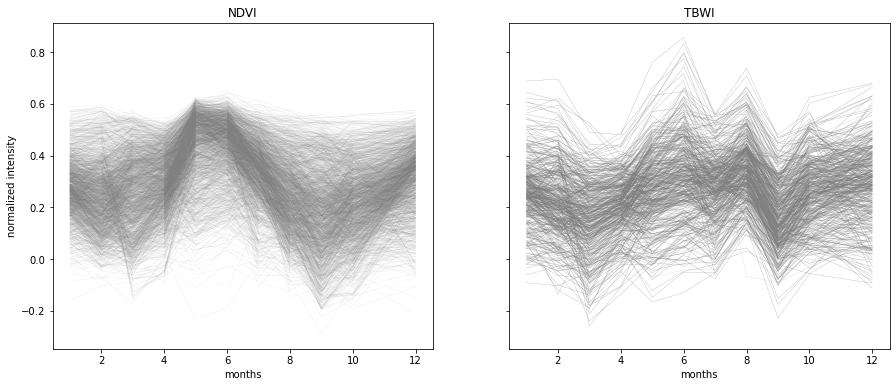

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6), sharex=True, sharey=True)

for i,j in np.ndindex(sampleChannel.shape):
    x,y = getPixelIntensity(i, j, NDVI)
    ax[0].plot(x, y, color='gray', lw=0.1, alpha=0.5)
ax[0].set(title='NDVI', xlabel='months', ylabel='normalized intensity')

for i,j in np.ndindex(sampleChannel.shape):
    x,y = getPixelIntensity(i, j, TBWI)
    ax[1].plot(x, y, color='gray', lw=0.1, alpha=0.5)
ax[1].set(title='TBWI', xlabel='months')

        
plt.show()

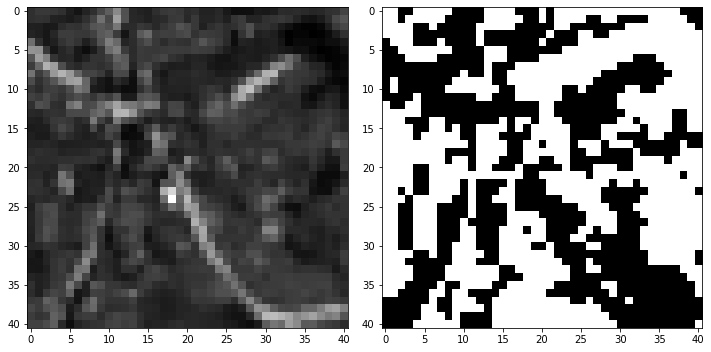

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
img = d[4][6] * NDVI[6] - NDVI[6]
img = img + abs(np.amin(img))
img = img / np.amax(img)
img[img > 0.5] = 0
img[img > 0] = 1

ax[0].imshow(d[4][6], cmap='gray')
ax[0].set_title('')
#ax[0].set_axis('off')
ax[1].imshow(img, cmap='gray')
#ax[1].set_axis('off')
plt.tight_layout()
plt.show()